In [3]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import os
import time
import random
import copy
import seaborn as sns
from utils.metrics import *

In [4]:
randdata=[42, 168, 573, 81, 1094 , 9,
 23, 1387, 937 ,1]  #  np.random.random_sample(10)
#print(randdata)

In [5]:
# setting random seed
SEED=randdata[1] # 42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
#     tf.config.threading.set_inter_op_parallelism_threads(1)
#     tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [6]:
dicnpy='../../dataCIC2017/'
dicdata='../../Datasets/CIC2017/'
groupnames=["Tuesday","Wednesday","Thursday","Friday"]#"Monday",
attack_types={0:"BENIGN",1:"FTP-Patator", 2:"SSH-Patator", 3:"DoS GoldenEye", 4:"DoS Hulk", 5:"DoS Slowhttptest", 6:"DoS slowloris", 7:"Heartbleed", 
                  8:"Web Attack � Brute Force", 9:"Web Attack � XSS", 10:"Web Attack � Sql Injection", 11:"Infiltration",12:"Bot", 13:"DDoS", 14:"PortScan",15:"AllAttack"} # "Web Attack ?Brute Force"
    # Web Attack ?Brute Force, Web Attack ?XSS, Web Attack ?Sql Injection 
dicoutcome='../../cic2017_checkpoints/'

In [7]:
def column_split_bina(ds):
    '''split dataset to data_x,data_y for binary classification '''
    if type(ds)==pd.DataFrame:
        data_x=np.asarray(ds.iloc[:,:-2]).astype(np.float32)
        data_y=np.asarray(ds.iloc[:,-1]).astype(np.float32)
    elif type(ds)==np.ndarray:
        data_x=ds[:,:-2].astype(np.float32)
        data_y=ds[:,-1].astype(np.float32)        
    else:
        data_x=False
        data_y=False
    return data_x, data_y

In [8]:
# Get the training data
try:
    normal_all=np.load(dicnpy+'Monday-0.npy', allow_pickle=True) 
except IOError:
    print("Monday-0.npy didn't exist!")
    
normal_train_x, _ =column_split_bina(normal_all)
normal_train_x = np.nan_to_num(normal_train_x)
original_dim = normal_train_x.shape[1]
klw=normal_train_x.shape[0]
input_shape = (original_dim,)
latent_inputs =tfk.Input(shape=(64,), name='z_sampling')

# BAE

In [9]:
# make_n_prior(64) =prior(64)
# make_mvn_prior(64) # MVN diag
# make_mvn_prior(64,offdiag=True)  # MVN Tril
# make_mixmvn_prior()  # mixture MVN
# Normal distribution
def make_n_prior(shape, dtype=np.float32,independent=False):
    if independent:
        return   tfd.Independent(tfd.Normal(loc=tf.zeros(shape), scale=1),  reinterpreted_batch_ndims=1)
    else:
        return tfd.Normal(loc=tf.zeros(shape), scale=1)

tfb = tfp.bijectors
def make_mvn_prior(ndim, trainable=False, offdiag=False):
        if not trainable:
            if offdiag:
                # With covariances
                # Note: Diag must be > 0, upper triangular must be 0, and lower triangular may be != 0.
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.zeros(ndim),
                    scale_tril=tf.eye(ndim)
                )
            else:            
                if True:  # kl_exact needs same dist types for prior and latent.
                    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(ndim), scale_diag=tf.ones(ndim))
                else:
                    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(ndim), scale=1),
                                            reinterpreted_batch_ndims=1)
        else:
            # Note, in TransformedVariable, the initial value should be that AFTER transform; weight trainable.
            if offdiag:
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_tril=tfp.util.TransformedVariable(
                        tf.random.normal([ndim, ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        tfb.FillScaleTriL(), name="prior_scale")
                )
            else:
                scale_shift = np.log(np.exp(1) - 1).astype(np.float32)
                prior = tfd.MultivariateNormalDiag(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_diag=tfp.util.TransformedVariable(
                        tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(scale_shift)]),
                        name="prior_scale"
                    )
                )                
        return prior

## VI

### dense layer

In [54]:
#2layers (128,64,32)

encoder=tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Dense(128,                
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.0001),    
        bias_initializer=  tf.zeros_initializer() ,
               kernel_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(128),use_exact_kl=True, weight=1.0) ,  
                bias_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(128),use_exact_kl=True, weight=1.0) ,
                           activation='relu'),

    tfkl.Dense(64,
        kernel_initializer=  tf.random_normal_initializer(mean=0, stddev=0.0001),   
        bias_initializer=tf.zeros_initializer() ,
                           kernel_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(64),use_exact_kl=True, weight=1.0) ,     
                bias_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(64),use_exact_kl=True, weight=1.0) ,
                     activation='relu'), 
    tfkl.BatchNormalization(momentum=0.95, epsilon=0.005,
                                beta_initializer=tf.random_normal_initializer(mean=0, stddev=0.05), 
                                ),
    
    #  BAE
    tfkl.Dense(32,
        kernel_initializer=  tf.random_normal_initializer(mean=0, stddev=0.0001),   
        bias_initializer=tf.zeros_initializer() ,
                kernel_regularizer=  tfpl.KLDivergenceRegularizer(make_mvn_prior(32),use_exact_kl=True, weight=1.0) ,    
                bias_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(32),use_exact_kl=True, weight=1.0) ,
                  activation='relu'),
      
    
#     ### Here uncomment for BAE-Hetero-Latent
#     tfkl.Dense(tfpl.DistributionLambda.params_size(32),              
#         kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.0001),
#         bias_initializer=tf.zeros_initializer() ),
#     tfpl.DistributionLambda( 
#         make_distribution_fn=lambda t: tfd.Normal(loc=t,   scale=1e-5 + tf.math.softplus(0.01 * t)))
    
#     ### Here uncomment for BAE-Hetero-Latent-VLB
#     tfkl.Dense(tfpl.DistributionLambda.params_size(32),              
#         kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.0001),
#         bias_initializer=tf.zeros_initializer() ),
#     tfpl.DistributionLambda( 
#         make_distribution_fn=lambda t: tfd.Normal(loc=t,   scale=1e-5 + tf.math.softplus(0.01 * t)),
#                                 activity_regularizer=tfpl.KLDivergenceRegularizer(make_mvn_prior(32),use_exact_kl=False, weight=1.0)) 
    
])               

encoder.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 128)               9984      
                                                                 
 dense_75 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_17 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 distribution_lambda_10 (Dis  ((None, 32),             0         
 tributionLambda)             (None, 32))                        
                                                                 
Total params: 20,576
Trainable params: 20,448
Non-tra

In [55]:
# decoder model 
latent_inputs =tfk. Input(shape=(32,), name='z_sampling')
x = tfkl.Dense(64,
        kernel_initializer= tf.random_normal_initializer(mean=0, stddev=0.0001),   
        bias_initializer=tf.zeros_initializer() ,   
             kernel_regularizer=  tfpl.KLDivergenceRegularizer(make_mvn_prior(64),use_exact_kl=True, weight=1.0) , 
                bias_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(64),use_exact_kl=True, weight=1.0) , 
                   activation='relu')(latent_inputs)

x = tfkl. Dense(128, 
        kernel_initializer= tf.random_normal_initializer(mean=0, stddev=0.0001),   
        bias_initializer=tf.zeros_initializer() ,
                kernel_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(128),use_exact_kl=True, weight=1.0) , 
                bias_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(128),use_exact_kl=True, weight=1.0) , 
                   activation='relu')(x)
    
# ### here uncomment for BAE-homo
#x=x+0.01

 # Here for BAE-Hetero-Latent  or BAE-Hetero-Latent-VLB or BAE-Homo or BAE-None
x_recons=tfkl.Dense(original_dim,
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.001),  
        bias_initializer=tf.zeros_initializer() ,
                    kernel_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(original_dim),use_exact_kl=True, weight=1.0) , 
                    bias_regularizer= tfpl.KLDivergenceRegularizer(make_mvn_prior(original_dim),use_exact_kl=True, weight=1.0) ,  
                    activation='sigmoid')(x)

# ###  Here uncomment for BAE-Hetero-Last
# x = tfkl. Dense(original_dim, 
#         kernel_initializer= tf.random_normal_initializer(mean=0, stddev=0.01),
#         bias_initializer=tf.zeros_initializer() ,
#                            kernel_regularizer=tfk.regularizers.L2(reg_L2),  
#                 bias_regularizer=tfk.regularizers.L2(reg_L2),
#                 activation='relu')(x)
# x_recons =tfp.layers.DistributionLambda(
#     lambda t: tfp.distributions.MultivariateNormalDiag(
#                    loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ))(x) 
 
decoder=tfk.Model(latent_inputs, x_recons, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 32)]              0         
                                                                 
 dense_77 (Dense)            (None, 64)                2112      
                                                                 
 dense_78 (Dense)            (None, 128)               8320      
                                                                 
 dense_79 (Dense)            (None, 77)                9933      
                                                                 
Total params: 20,365
Trainable params: 20,365
Non-trainable params: 0
_________________________________________________________________


In [56]:
class BAE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="bae", **kwargs):
        super(BAE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        self.decoder = decoder
        #self.kl_weight = kl_weight
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        #self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        z_sample=self.encoder(x_input)                
        x_recons= decoder(z_sample   )#.sample() )
        
        return x_recons
    
    def train_step(self,x_true):
        with tf.GradientTape() as tape:
            z_sample=self.encoder(x_true)
            x_recons= decoder(z_sample  )#.sample())
            
            reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons))   # crossentropy
            #reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            
            total_loss =reconstruction_loss #+loss_para #+kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
           # "kl_loss": self.kl_loss_tracker.result(),
        }
    

## MC-dropout

In [10]:
dropout_rate=0.2
reg_L2= 1e-7   

### model

In [17]:

from tensorflow.keras.initializers import RandomNormal, Constant
#2layers (128,64,32)

ini_inputs=tfk. Input(shape=(original_dim,))
x = tfkl.Dense( 128,             
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.0001),   
        bias_initializer=  tf.zeros_initializer() ,      
               kernel_regularizer=tfk.regularizers.L2(reg_L2),  
               bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                           activation='relu')(ini_inputs)  
x=tfkl.Dropout(dropout_rate)(x,training=True)
    
x=tfkl.Dense(64,
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.0001), 
        bias_initializer=tf.zeros_initializer() ,   
                           kernel_regularizer=tfk.regularizers.L2(reg_L2) ,         
                bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                           activation='relu')(x)       
x=tfkl.Dropout(dropout_rate)(x,training=True) 
x=tfkl.BatchNormalization(momentum=0.95, epsilon=0.005,
                                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                                )(x)

x=tfkl.Dense(32,                
        kernel_initializer=  tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=  tf.zeros_initializer() , 
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),  
               bias_regularizer=tfk.regularizers.L2(reg_L2),
                     activation='relu') (x)   
    
#  Here uncomment for BAE-None, BAE-Homo, BAE-Heter-Last
z_outputs= x 
    
### Here uncomment for BAE-Hetero-Latent                           
# z_outputs= tfp.layers.DistributionLambda(
#     lambda t: tfp.distributions.MultivariateNormalDiag(
#                    loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) )) (x)
                   
                            
# ### Here uncomment for BAE-Hetero-Latent-VLB
# z_outputs=  tfp.layers.DistributionLambda(
#     lambda t: tfp.distributions.MultivariateNormalDiag(
#                    loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ),
#       activity_regularizer=tfpl.KLDivergenceRegularizer(make_mvn_prior(32),use_exact_kl=False, weight=1.0)) (x)
  
    
encoder=tfk.Model(ini_inputs, z_outputs, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 77)]              0         
                                                                 
 dense_7 (Dense)             (None, 128)               9984      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                           

2023-09-17 00:10:55.941631: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [18]:
# decoder model 

latent_inputs =tfk. Input(shape=(32,), name='z_sampling')
x = tfkl.Dense( 64,
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.0001),  #
        bias_initializer=      tf.zeros_initializer() , #   
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),  
               bias_regularizer=tfk.regularizers.L2(reg_L2) , 
               activation='relu')(latent_inputs)

x= tfkl.Dropout(dropout_rate)(x,training=True)
x = tfkl. Dense( 128, 
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.0001), #
        bias_initializer= tf.zeros_initializer() ,  #
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),   
                bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                activation='relu')(x)
x= tfkl.Dropout(dropout_rate)(x,training=True)

# ### here uncomment for BAE-homo
#x=x+0.01

# Here uncomment for BAE-Hetero-Latent or BAE-Hetero-Latent-VLB or BAE-Homo or BAE-None
x_recons=tfkl.Dense(original_dim,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer= tf.zeros_initializer() , #tfk.initializers.he_normal(),  #
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),   
                    bias_regularizer=tfk.regularizers.L2(reg_L2),
                    activation='sigmoid')(x)

# ###  Here uncomment for BAE-Hetero-Last
# x = tfkl. Dense(original_dim, 
#         kernel_initializer= tf.random_normal_initializer(mean=0, stddev=0.01),
#         bias_initializer=tf.zeros_initializer() ,
#                            kernel_regularizer=tfk.regularizers.L2(reg_L2),  
#                 bias_regularizer=tfk.regularizers.L2(reg_L2),
#                 activation='relu')(x)
# x_recons =tfp.layers.DistributionLambda(
#     lambda t: tfp.distributions.MultivariateNormalDiag(
#                    loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ))(x) 
 

decoder=tfk.Model(latent_inputs, x_recons, name='decoder')  # for reconstruction error, mae,mse

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 32)]              0         
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 77)                9933      
                                                                 
Total params: 20,365
Trainable params: 20,365
Non-trainable

### model class

In [19]:
 
class BAE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="bae", **kwargs):
        super(BAE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        self.decoder = decoder
        #self.kl_weight = kl_weight
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        #self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        z_sample=self.encoder(x_input)  
        x_recons=self. decoder(z_sample  )# .sample() )             
        return x_recons                    
    
    def train_step(self,x_true):
        with tf.GradientTape() as tape:            
            z_sample=self.encoder(x_true)
            x_recons=self. decoder(z_sample   )# .sample() )
            
            reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons))   # crossentropy
            #reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            
            total_loss =reconstruction_loss #+loss_para #+kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
           # "kl_loss": self.kl_loss_tracker.result(),
        }
    

# Training model

In [14]:
M= 5
savename='cic2017-44-dropout-latent-seed1-bce'

In [15]:
# scale data
t = MinMaxScaler()
t.fit(normal_train_x)
normal_train_x = t.transform(normal_train_x)

In [20]:
# compile and train tfk.Model
BDL_model = BAE_AD(orig_dim=original_dim)
BDL_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-10,amsgrad=True))
batchsize=512
epochsize=100
start=time.time()
train_history= BDL_model.fit(normal_train_x, batch_size=batchsize,epochs=epochsize,shuffle=True)
end=time.time()
print(f"\nTime to training: {round(end-start,5)} seconds.")

Epoch 1/100
518/518 [==============================] - 6s 8ms/step - loss: 1.3470 - reconstruction_loss: 0.7492
Epoch 2/100
518/518 [==============================] - 4s 8ms/step - loss: 0.2150 - reconstruction_loss: 0.1890
Epoch 3/100
518/518 [==============================] - 4s 8ms/step - loss: 0.1484 - reconstruction_loss: 0.1431
Epoch 4/100
518/518 [==============================] - 4s 8ms/step - loss: 0.1321 - reconstruction_loss: 0.1298
Epoch 5/100
518/518 [==============================] - 4s 8ms/step - loss: 0.1243 - reconstruction_loss: 0.1227
Epoch 6/100
518/518 [==============================] - 4s 8ms/step - loss: 0.1193 - reconstruction_loss: 0.1181
Epoch 7/100
518/518 [==============================] - 4s 8ms/step - loss: 0.1150 - reconstruction_loss: 0.1144
Epoch 8/100
518/518 [==============================] - 4s 8ms/step - loss: 0.1123 - reconstruction_loss: 0.1117
Epoch 9/100
518/518 [==============================] - 4s 8ms/step - loss: 0.1100 - reconstruction_loss:

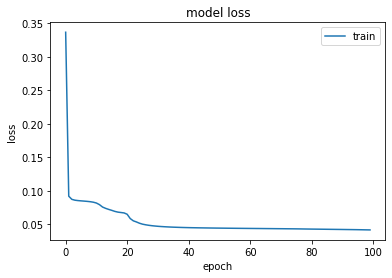

In [36]:

pyplot.plot(train_history.history['loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper right');
pyplot.show()

# save or load model

In [21]:
# Save the weights
BDL_model.save_weights('./cic2017_checkpoints/'+savename)

In [16]:
BDL_model = BAE_AD(orig_dim=original_dim)
oldername='cic2017-44-dropout-vae-seed-diag-dp-mae'  #  None # to replace the file name
## Restore the weights
BDL_model.load_weights('./cic2017_checkpoints/'+oldername)  
#savename='cic2017-1-vi-input-mae'  

## Evaluate the model
#loss, acc =bae_model.evaluate(normal_train_x)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# function set

In [22]:
def get_error_term(v1,v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1-v2)**2,axis=1))
    else:        #return MAE
        return np.mean(abs(v1-v2),axis=1)

In [23]:
def metric3UQ(fileforname, attacknum):
    pd_reader=pd.read_csv('../../pplots/BDL'+fileforname+'+allmetrics.csv' )  #,skiprows=251)   
    save_path = "pplots/BDL"+fileforname+'+allmetricsSum'+".csv"

    #print(pd_reader.head())
    modelname='BDL'
    model_dict_total={}
    model_dict_alea={}
    model_dict_epis={}
    model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
    model_dict_alea["metricname"]=pd_reader.iloc[17,1:19]
    model_dict_epis["metricname"]=pd_reader.iloc[17,1:19]
    for each in range(1,attacknum) : # len( attack_types[:attacknum])):
        fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
        fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')

        for i in range(1,len(pd_reader) ,18*3):
            if '+' in pd_reader.iloc[i,0] :

                if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                    legendd=pd_reader.iloc[i,0].split('+')[0]

                    if legendd in model_dict_total.keys():
                        model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                        model_dict_alea[legendd]=model_dict_alea[legendd]+pd_reader.iloc[i+17+18,1:19].astype(np.float16)
                        model_dict_epis[legendd]=model_dict_epis[legendd]+pd_reader.iloc[i+17+18+18,1:19].astype(np.float16)
                    else: 
                        model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16)    
                        model_dict_alea[legendd]=pd_reader.iloc[i+17+18,1:19].astype(np.float16) 
                        model_dict_epis[legendd]=pd_reader.iloc[i+17+18*2,1:19].astype(np.float16) 

                    #fig_title=pd_reader.iloc[i,0]
                    try:
                        xx=pd_reader.iloc[i+2,1:].astype(int)
                    except:
                        print(i)

                    # total uncertainty
                    y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                    y_uncer2=pd_reader.iloc[i+15+18,1:].astype(np.float16)  # alea
                    y_uncer3=pd_reader.iloc[i+15+18*2,1:].astype(np.float16)   #epis
                    #plot_title=pd_reader.iloc[i+2,0]            
                    #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # auc
                    y_values=pd_reader.iloc[i+9,1:].astype(np.float16)   # accu_total
                    y_values2=pd_reader.iloc[i+9+18,1:].astype(np.float16)   # accu_alea
                    y_values3=pd_reader.iloc[i+9+18*2,1:].astype(np.float16)   # accu_epis

                    # ACCU_total
                    ax1.plot(xx,y_values,label=legendd)                
                    ax1.fill_between(xx,y_values-np.absolute(y_uncer),y_values+np.absolute(y_uncer),alpha=0.3,facecolor='grey')
                    ax1.set(ylabel='Percent')              
                    # ACCU_alea
                    ax2.plot(xx, y_values2) # , 'tab:green')        
                    ax2.fill_between(xx,y_values2-np.absolute(y_uncer2),y_values2+np.absolute(y_uncer2),alpha=0.3,facecolor='grey')        
                    # ACCU_epis
                    ax3.plot(xx, y_values3 ) #, 'tab:orange') 
                    ax3.fill_between(xx,y_values3-np.absolute(y_uncer3),y_values3+np.absolute(y_uncer3),alpha=0.3,facecolor='grey')         

                    # AUC
                    ax4.plot(xx, pd_reader.iloc[i+3,1:].astype(np.float16) ) # , 'tab:red') 

                    #ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test

                    if each==1:
                        ax1.set_title('Total')
                        ax2.set_title('Aleatoric') 
                        ax3.set_title('epistemic')
                        ax4.set_title('AUC') 
                    if each==len(attack_types)-1:
                        ax1.set(xlabel='Rejection')
                        ax2.set(xlabel='Rejection')
                        ax3.set(xlabel='Rejection')
                        ax4.set(xlabel='Rejection')
                  
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))

        for ax in fig.get_axes():
            ax.label_outer()
            ax.set_xlim(0,60)
            ax.set_ylim(0,1)
       
        pyplot.show()

    for aproblegend in model_dict_total.keys():
        if aproblegend != 'metricname':
            model_dict_total[aproblegend]=model_dict_total[aproblegend]/(attacknum-1) # (len(attack_types)-1)
            model_dict_alea[aproblegend]=model_dict_alea[aproblegend]/ (attacknum-1)  # (len(attack_types)-1)
            model_dict_epis[aproblegend]=model_dict_epis[aproblegend]/(attacknum-1) # (len(attack_types)-1)
        
    save_data=pd.DataFrame(model_dict_total)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
    save_data=pd.DataFrame(model_dict_alea)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
    save_data=pd.DataFrame(model_dict_epis)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

# testing+ more dist

In [24]:

alluncertainty_dict={}     # record all UQ under multiple distributions on anoamly score.
all_AS_AP_dict={}    # record all anoamly scores and anoamly probabilities in T times repeats. the defalut is mae reconstruction error.
all_AS_AP_2_dict={}   # record the second anoamly score through another reconstruction error measure method. e.g. rmse
all_test_y_2_dict={}
newname=savename+'-mae' #+'11'

T= M      # the times of prediction, i.e. the number of parameters sample sets.
distribution_types=['G1',  'Gamma','T', 'G2', 'Uniform','ECDF', 'Triang']       
'''
G1: standard Gaussian, i.e. mean=0,std=1
G2: customized Gaussian using CDF()
'''
#start to timeing
start=time.time()
for attackindex in range(1,16):     #16, the 15th including all attack types  
    cont=np.load(dicnpy+"test-"+str(attackindex)+".npy",allow_pickle=True)    
    print(f'the {attackindex}th attack data with name of {attack_types[attackindex]}')
    test_x,test_y=column_split_bina(cont)
    test_x = np.nan_to_num(test_x)
                
    if type(test_x)==False:
        print('test_x is False!')
    for i in range(0,len(test_y)):
        if test_y[i]!=0:
            test_y[i]=1
    
    all_test_y_2_dict[attackindex]=test_y
    # scale data
    t = MinMaxScaler()
    t.fit(test_x)
    test_x2 = t.transform(test_x)

    mean_G1, mean_G2, mean_Gamma,  mean_Uniform,mean_Triang, mean_T,mean_ECDF=0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores

    for i in range(0,T):  
        test_recon=BDL_model.predict(test_x2)
        
        mae_vector = get_error_term(test_recon, test_x2, _rmse=False) 
        all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)]=mae_vector
        mean_AS=mean_AS+mae_vector
        
        mse_vector=get_error_term(test_recon, test_x2, _rmse=True) 
        all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)]=mse_vector
        
        # test 2.1------------------------standard Gaussian------------------------------------
        mae_vector_prob=copy.deepcopy(mae_vector)
        #mae_vector_prob=regular_log(mae_vector)   ######################
        #mae_vector_prob=regular_linear(mae_vector) 
        # 1.the anomaly scores following Gaussian distribution        
        mae_vector_prob=normalization_gaussian_1( mae_vector_prob)    
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G1']=mae_vector_prob
        mean_G1=mean_G1+mae_vector_prob
        
         #-------------------Customized Gaussian using CDF-----------------------------------------
        mae_vector_prob=[]   
        mae_vector_prob=copy.deepcopy(mae_vector)
        #mae_vector_prob=regular_log(mae_vector)   ######################
        #mae_vector_prob=regular_linear(mae_vector) 
        # 2.the anomaly scores following Gaussian distribution    
        mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G2']=mae_vector_prob 
        mean_G2=mean_G2+mae_vector_prob
        
        
        # 4.the anomaly scores following Gamma distribution -----------------------------------------------
        mae_vector_prob=[] 
        mae_vector_prob=copy.deepcopy(mae_vector )  
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)     
        mae_vector_prob=normalization_gamma(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Gamma']=mae_vector_prob
        mean_Gamma=mean_Gamma+mae_vector_prob
        
        
         # 6.the anomaly scores following uniform distribution -----------------------------------    
        mae_vector_prob=[] 
        mae_vector_prob=copy.deepcopy(mae_vector) 
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)                   
        mae_vector_prob=normalization_uniform(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Uniform']=mae_vector_prob
        mean_Uniform=mean_Uniform+mae_vector_prob
        
         # 7.the anomaly scores following triang distribution   ----------------------------------    
        mae_vector_prob=[] 
        mae_vector_prob=copy.deepcopy(mae_vector )   
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)                 
        mae_vector_prob=normalization_triang(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Triang']=mae_vector_prob
        mean_Triang=mean_Triang+mae_vector_prob

        
         # 8.the anomaly scores following students T distribution   ----------------------------------    
        mae_vector_prob=[] 
        mae_vector_prob=copy.deepcopy(mae_vector)
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)                  
        mae_vector_prob=normalization_t(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_T']=mae_vector_prob
        mean_T=mean_T+mae_vector_prob
        '''
        # test 9 -----------------------pure CDF-------------------------------------
        # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
        #3. alternative: pure cdf()   
        #mae_vector_prob=stats.norm.cdf(mae_vector)  
        '''
        #-------------------------------ECDF-----------------------------------------
        # 3.1 ecdf       
        mae_vector_prob=[] 
        mae_vector_prob=copy.deepcopy(mae_vector)
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)
        mae_vector_prob=normalization_ECDF(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECDF']=mae_vector_prob
        mean_ECDF=mean_ECDF+mae_vector_prob
       
    mean_AP={}
    mean_AP['AS']=mean_AS/T
    mean_AP['G1']=mean_G1/T
    mean_AP['G2']=mean_G2/T
    mean_AP['Gamma']=mean_Gamma/T
    mean_AP['Uniform']=mean_Uniform/T
    mean_AP['Triang']=mean_Triang/T
    mean_AP['T']=mean_T/T
    mean_AP['ECDF']=mean_ECDF/T
    mean_G1, mean_G2, mean_Gamma, mean_Uniform,mean_Triang, mean_T,mean_ECDF=0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores

    mean_alea={}
    mean_epis={}
    for dist in distribution_types:
        mean_alea[dist]=0
        mean_epis[dist]=0

    mean_AS_alea=0
    mean_AS_epis=0

    for i in range(0,T):  
        mean_AS_alea+= all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)]*(1-all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
        mean_AS_epis +=(all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)] - mean_AP['AS'])**2  

        for dist in distribution_types:
            if all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                mean_alea[dist] += np.mean(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                mean_epis[dist] += (np.mean(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                
            else:
                mean_alea[dist] += all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                mean_epis[dist] +=(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                
    mean_AS_alea=mean_AS_alea/T 
    mean_AS_epis=mean_AS_epis/T
    alluncertainty_dict[attack_types[attackindex]+'_AS_alea']=mean_AS_alea
    alluncertainty_dict[attack_types[attackindex]+'_AS_epis']=mean_AS_epis
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea+mean_AS_epis, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_epis, y_true=test_y,plot=False) 

    for dist in distribution_types:
        mean_alea[dist]=mean_alea[dist]/T 
        mean_epis[dist]=mean_epis[dist]/T                     
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_alea']=mean_alea[dist] 
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_epis']=mean_epis[dist]
        uncer_total=mean_alea[dist] +mean_epis[dist]
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=uncer_total, y_true=test_y,plot=False)  #uncer_total
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=mean_alea[dist], y_true=test_y,plot=False) 
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                    unc_total=mean_epis[dist], y_true=test_y,plot=False) 

    #break
    
end=time.time()                 
runTime=pd.DataFrame({'ModelName':['BDL'+savename],'Phase':['test'],'M':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)],'batch':[0],'epoch':[0]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)

del result_dic,   mean_G1, mean_G2, mean_Gamma, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_AS, mean_AP
del mae_vector, mse_vector, mae_vector_prob,uncer_total,mean_alea,mean_epis,mean_AS_alea,mean_AS_epis

the 1th attack data with name of FTP-Patator


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 2th attack data with name of SSH-Patator


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 3th attack data with name of DoS GoldenEye


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

the 4th attack data with name of DoS Hulk


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 5th attack data with name of DoS Slowhttptest


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 6th attack data with name of DoS slowloris


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

the 7th attack data with name of Heartbleed


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 8th attack data with name of Web Attack � Brute Force


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 9th attack data with name of Web Attack � XSS


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 10th attack data with name of Web Attack � Sql Injection


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 11th attack data with name of Infiltration


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 12th attack data with name of Bot


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 13th attack data with name of DDoS


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 14th attack data with name of PortScan


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 15th attack data with name of AllAttack


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

In [25]:
# for mae anomaly score
uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"   # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
save_uncer = pd.DataFrame.from_dict(alluncertainty_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del uncer_save_path,ASAP_save_path,save_uncer,save_ASAP, alluncertainty_dict,all_AS_AP_dict


cic2017-44-dropout-latent-seed1-dTril-bce-mae


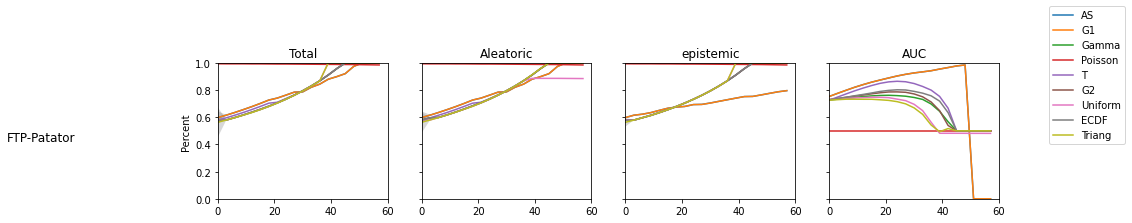

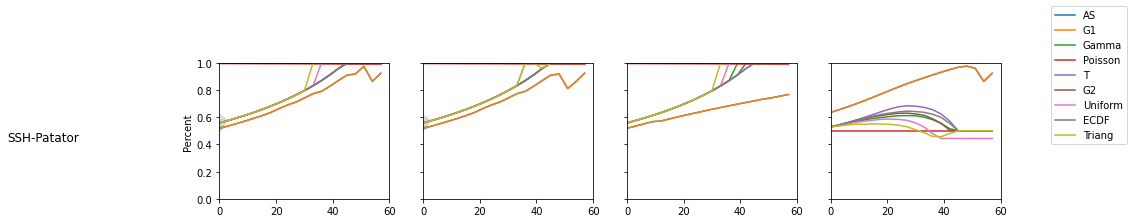

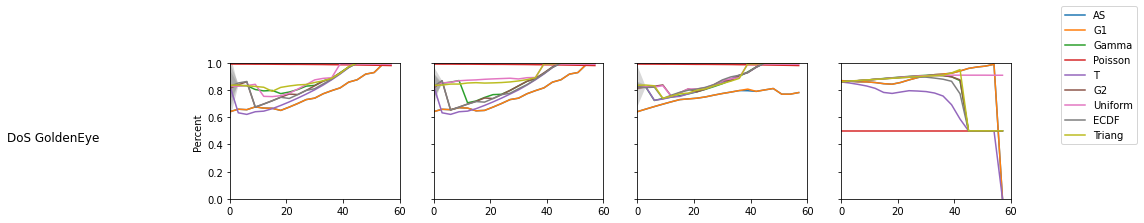

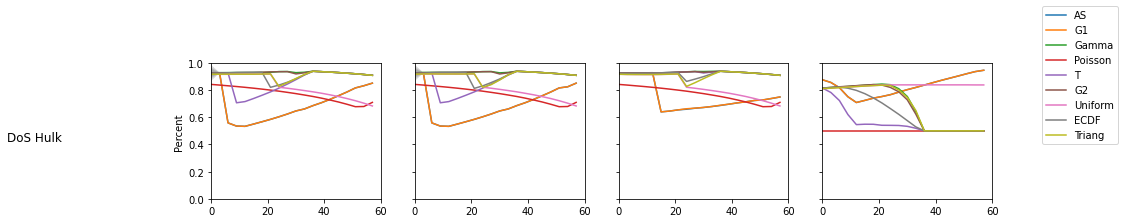

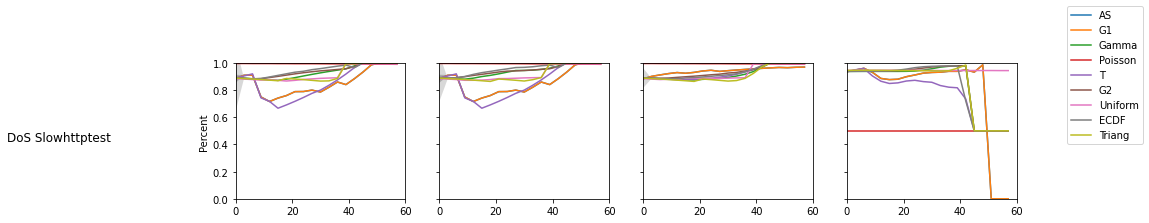

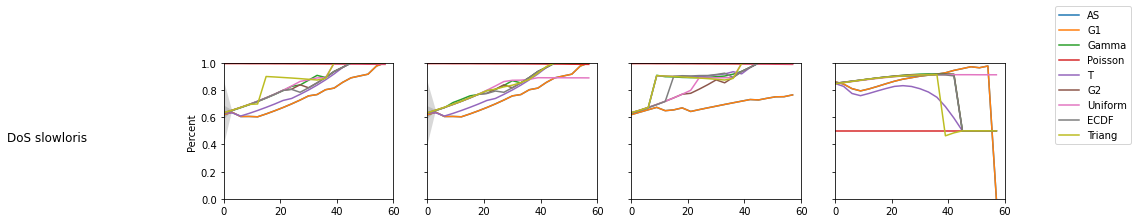

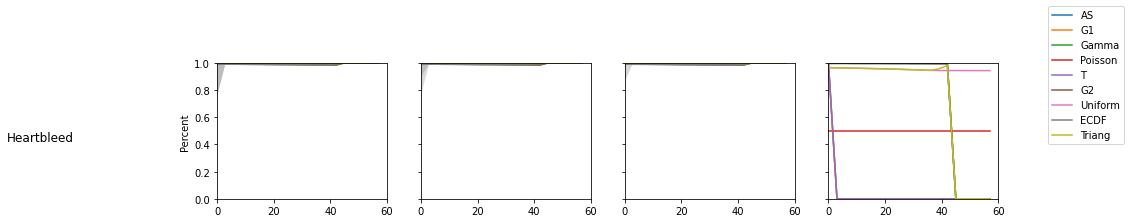

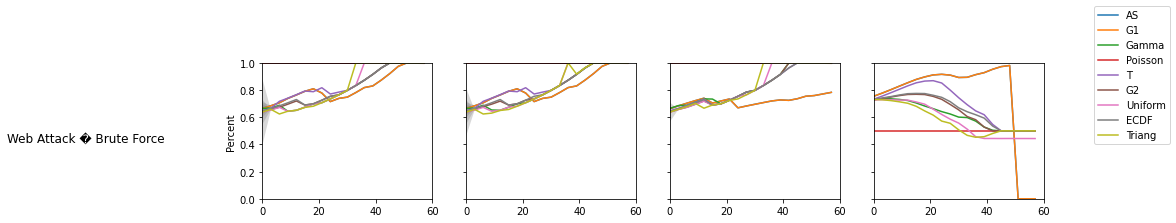

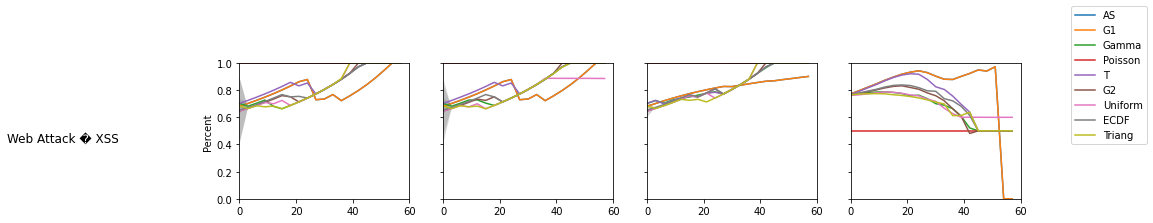

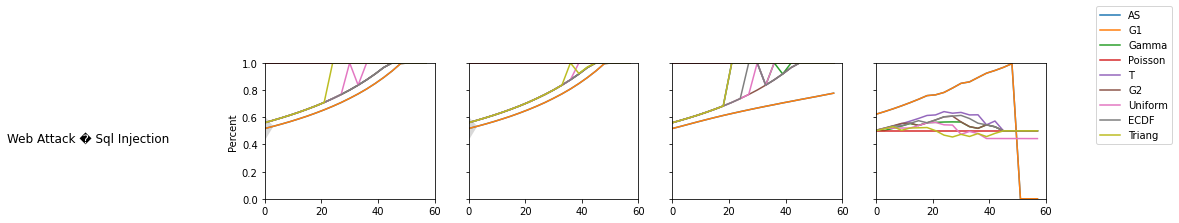

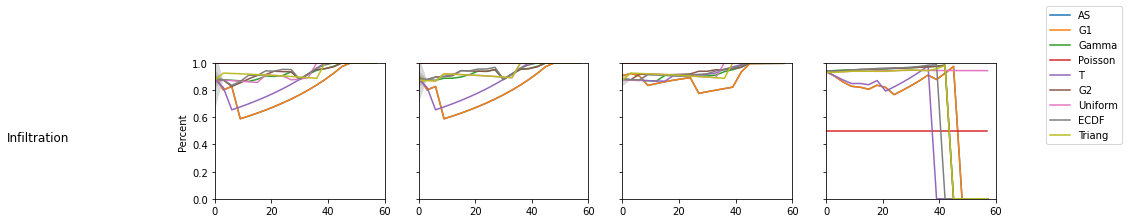

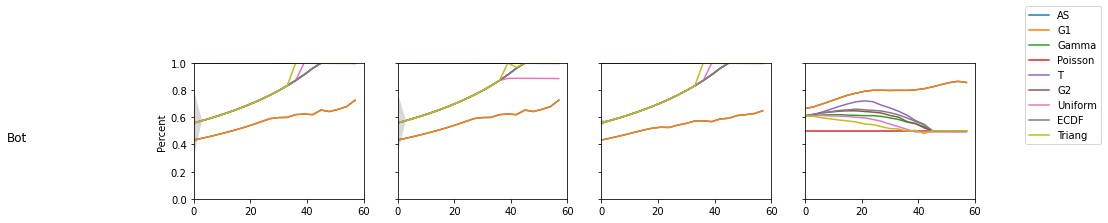

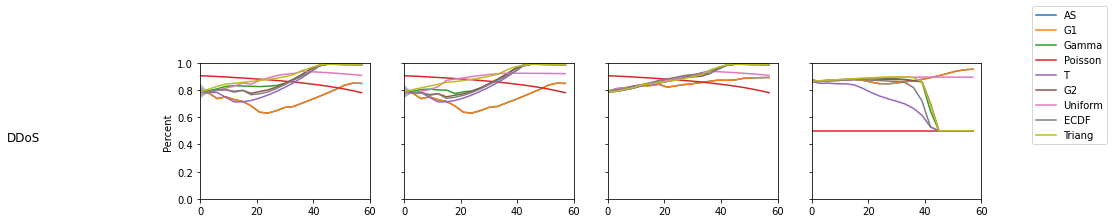

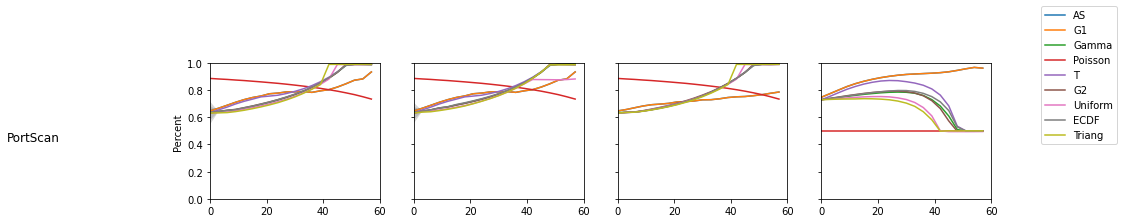

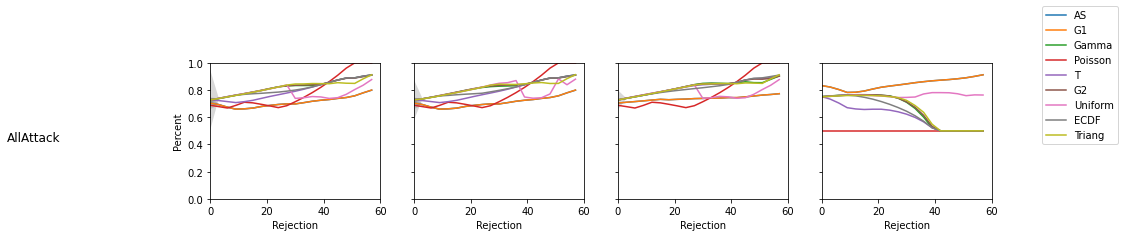

In [26]:
print(newname)
metric3UQ(newname,16)